# Nuclie Semantic Segmentation - UNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
os.getcwd()

'/Users/cusniwtt/Documents/Playgrounds/UNet'

In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask


# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]

Getting and resizing test images ... 



100%|██████████| 12/12 [00:00<00:00, 23.29it/s]

Done!


## Visualize imported data

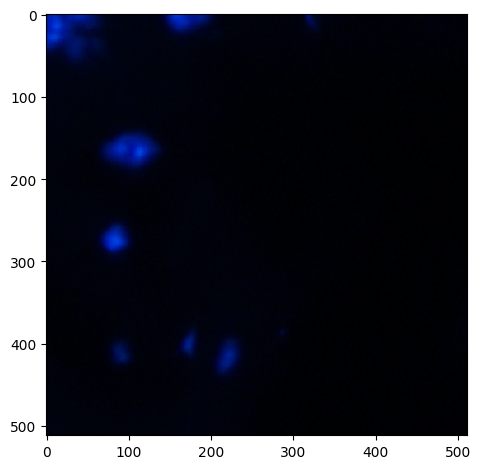

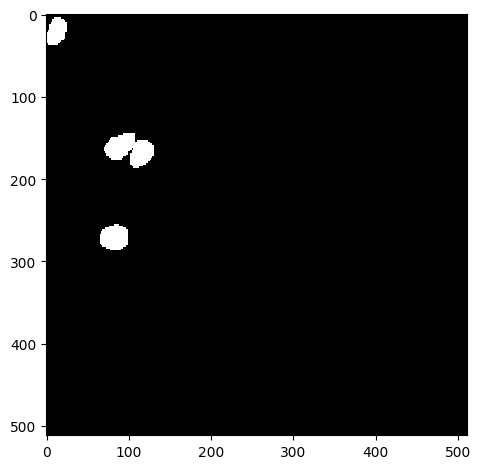

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="UNet" style="height: 400px; width:600px;"/>

## U-Net baseline

In [6]:
# Build U-Net model
filters = 64
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(filters*3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(filters*3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(filters*5, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(filters*5, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(filters*3, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters*3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(filters*3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(filters/2, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs], name='U-Net_baseline')
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "U-Net_baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
        

### Optimizer Loss Metrics

In [7]:
# Optimizer
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.002, decay=0.00003, momentum=0.9)
adam = optimizers.Adam(learning_rate=0.002, decay=0.00003)

# Loss function
from keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()

# Metrics
from keras.metrics import Recall, Precision, BinaryIoU
recall = Recall()
precision = Precision()
binIoU = BinaryIoU(target_class_ids=[0], threshold=0.5)

# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopper = EarlyStopping(patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

In [8]:
from keras import initializers

def resetWeights(model):
    # Reset the weights of the model
    weight_shapes = [w.shape for w in model.get_weights()]
    new_weights = [initializers.RandomNormal(mean=0.0, stddev=0.05)(shape) for shape in weight_shapes]
    model.set_weights(new_weights)

### Train model

In [9]:
# Adam, BCE, batch_size=8
model.compile(optimizer=adam, loss=bce, metrics=[recall, precision])
checkpointer = ModelCheckpoint('unet_checkpoint_adam_bce_8.h5', verbose=1, save_best_only=True)
results_adam_bce_8 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100, 
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
resetWeights(model)

# SGD, BCE, batch_size=8
model.compile(optimizer=sgd, loss=bce, metrics=[recall, precision])
checkpointer = ModelCheckpoint('unet_checkpoint_sgd_bce_8.h5', verbose=1, save_best_only=True)
results_sgd_bce_8 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100,
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
resetWeights(model)

# Adam, BCE, batch_size=16
model.compile(optimizer=adam, loss=bce, metrics=[recall, precision])
checkpointer = ModelCheckpoint('unet_checkpoint_adam_bce_16.h5', verbose=1, save_best_only=True)
results_adam_bce_16 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100,
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
resetWeights(model)

# SGD, BCE, batch_size=16
model.compile(optimizer=sgd, loss=bce, metrics=[recall, precision])
checkpointer = ModelCheckpoint('unet_checkpoint_sgd_bce_16.h5', verbose=1, save_best_only=True)
results_sgd_bce_16 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100,
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
resetWeights(model)

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.5935 - recall: 0.8642 - precision: 0.2918
Epoch 1: val_loss improved from inf to 324.01596, saving model to unet_checkpoint_adam_bce_8.h5
12/12 [==============================] - 51s 4s/step - loss: 0.5935 - recall: 0.8642 - precision: 0.2918 - val_loss: 324.0160 - val_recall: 1.0000 - val_precision: 0.0707 - lr: 0.0020
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.4081 - recall: 0.8208 - precision: 0.5837
Epoch 2: val_loss did not improve from 324.01596
12/12 [==============================] - 50s 4s/step - loss: 0.4081 - recall: 0.8208 - precision: 0.5837 - val_loss: 26449.7715 - val_recall: 1.0000 - val_precision: 0.0707 - lr: 0.0020
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.3273 - recall: 0.8067 - precision: 0.6119
Epoch 3: val_loss did not improve from 324.01596
12/12 [==============================] - 61s 5s/step - loss: 0.3273 - recall: 0.8067 - precision:

InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/jf/lsmfc7bs28lcf730tztyl6vw0000gn/T/ipykernel_35078/3140785720.py", line 11, in <module>
      results_sgd_bce_8 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100,
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1445, in fit
      val_logs = self.evaluate(
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1502, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/metrics/metrics.py", line 949, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.debugging.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/jf/lsmfc7bs28lcf730tztyl6vw0000gn/T/ipykernel_35078/3140785720.py", line 11, in <module>
      results_sgd_bce_8 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100,
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1445, in fit
      val_logs = self.evaluate(
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1502, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/metrics/metrics.py", line 949, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.debugging.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (U-Net_baseline/conv2d_18/Sigmoid:0) = ] [[[[nan][nan][nan]]]...] [y (Cast_3/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal/Assert/AssertGuard/branch_executed/_9/_51]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (U-Net_baseline/conv2d_18/Sigmoid:0) = ] [[[[nan][nan][nan]]]...] [y (Cast_3/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_22119]

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0][0].plot(results.epoch, results.history["loss"], label="Train loss")
axs[0][0].plot(results.epoch, results.history["val_loss"], label="Validation loss")
axs[0][0].plot(results.epoch, results.history["precision"], label="Train precision")
axs[0][0].plot(results.epoch, results.history["val_precision"], label="Validation precision")
axs[0][0].plot(results.epoch, results.history["recall"], label="Train recall")
axs[0][0].plot(results.epoch, results.history["val_recall"], label="Validation recall")

axs[0][0].legend()
axs[0][0].legend()
axs[0][0].legend()

axs[0][0].set_ylim([0, 1])
axs[0][0].set_ylim([0, 1])
axs[0][0].set_ylim([0, 1])


# Make predictions

In [ ]:
# Predict on train, val and test
model = load_model('unet_checkpoint_adam_bce.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

2023-03-16 04:25:14.052302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 298ms/step


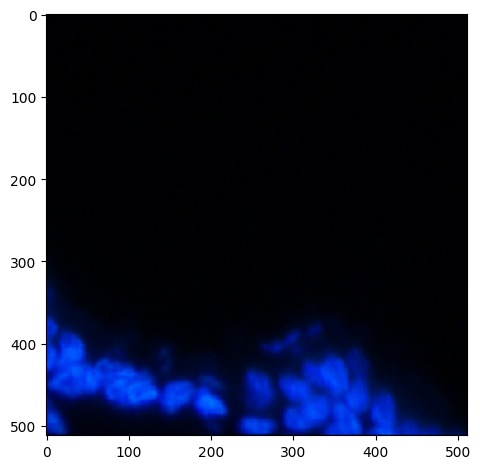

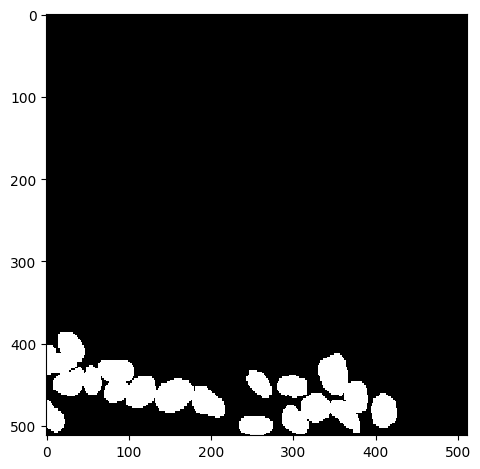

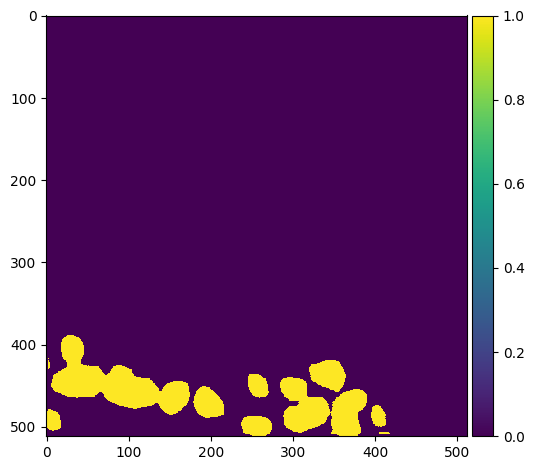

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

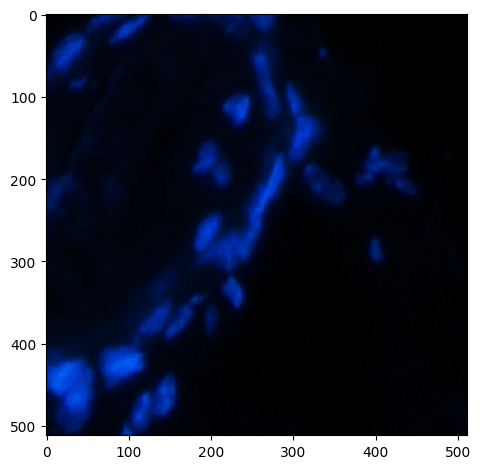

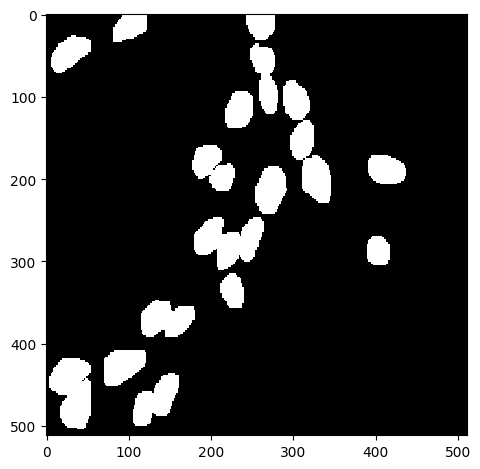

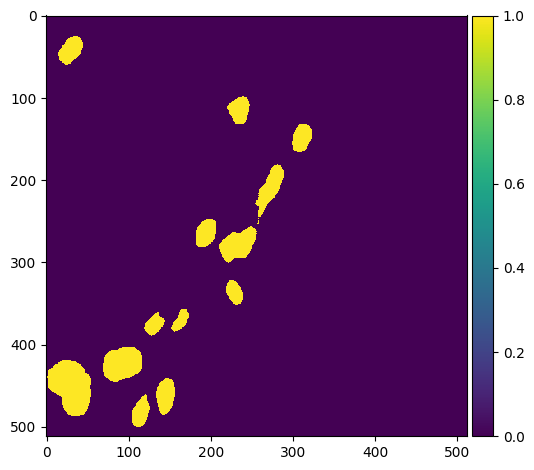

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Encode and submit our results

- [Link](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) has an excellent implementation of run-length encoding.

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

- Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

- Create submission

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)